[*********************100%%**********************]  1 of 1 completed


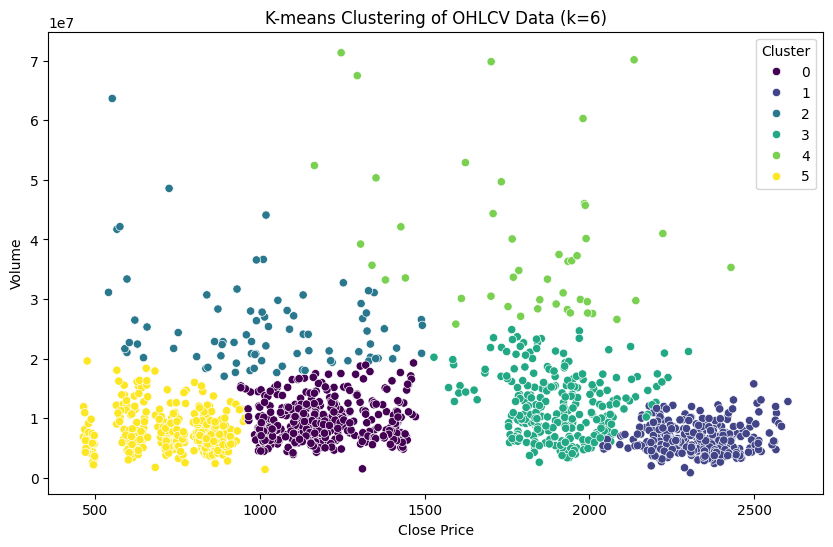

   Cluster  Best_Strategy
0        5            2.0
1        2            5.0
2        0            3.0
3        4            5.0
4        3            3.0
5        1            3.0


In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
from backtesting import Backtest, Strategy
from backtesting.lib import crossover

# Custom indicator functions using NumPy
def SMA(arr, n):
    """Simple Moving Average"""
    sma = np.convolve(arr, np.ones(n), 'valid') / n
    return np.concatenate([np.full(n-1, np.nan), sma])


def EMA(arr, n):
    """Exponential Moving Average"""
    alpha = 2 / (n + 1)
    ema = np.empty_like(arr)
    ema[:n] = np.nan
    ema[n] = arr[:n].mean()
    for i in range(n + 1, len(arr)):
        ema[i] = alpha * arr[i] + (1 - alpha) * ema[i - 1]
    return ema


def RSI(arr, n=14):
    """Relative Strength Index"""
    deltas = np.diff(arr)
    seed = deltas[:n]
    up = seed[seed >= 0].sum() / n
    down = -seed[seed < 0].sum() / n
    rs = up / down
    rsi = np.zeros_like(arr)
    rsi[:n] = 100. - 100. / (1. + rs)

    for i in range(n, len(arr)):
        delta = deltas[i - 1]  # Diff is 1 shorter
        if delta > 0:
            up_val = delta
            down_val = 0.
        else:
            up_val = 0.
            down_val = -delta

        up = (up * (n - 1) + up_val) / n
        down = (down * (n - 1) + down_val) / n

        rs = up / down
        rsi[i] = 100. - 100. / (1. + rs)

    return np.concatenate([[np.nan]*(n-1), rsi[n-1:]])


def BBANDS(arr, n=20, k=2):
    """Bollinger Bands"""
    sma = np.convolve(arr, np.ones(n), 'valid') / n
    std = np.array([np.std(arr[i-n:i]) for i in range(n, len(arr) + 1)])
    upper = sma + (std * k)
    lower = sma - (std * k)
    pad = np.full(n-1, np.nan)
    return np.concatenate([pad, upper]), np.concatenate([pad, sma]), np.concatenate([pad, lower])


def MACD(arr, n_fast=12, n_slow=26, n_signal=9):
    """Moving Average Convergence Divergence"""
    ema_fast = EMA(arr, n_fast)
    ema_slow = EMA(arr, n_slow)
    macd = ema_fast - ema_slow
    signal = EMA(macd[n_slow - 1:], n_signal)
    macd[:n_slow - 1] = np.nan
    signal = np.concatenate([np.full(n_slow - 1, np.nan), signal])
    return macd, signal


# Step 1: Download OHLCV data from Yahoo Finance
ticker = 'RELIANCE.NS'  # You can change this to any other ticker
start_date = '2017-01-01'
end_date = '2022-12-31'
df = yf.download(ticker, start=start_date, end=end_date)

# Step 2: Preprocess the data
df = df[['Open', 'High', 'Low', 'Close', 'Volume']]
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df)

# Step 3: Apply K-means Clustering
num_clusters = 6
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
df['Cluster'] = kmeans.fit_predict(scaled_data)

# Step 4: Visualize the Clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df['Close'], y=df['Volume'], hue=df['Cluster'], palette='viridis')
plt.title(f'K-means Clustering of OHLCV Data (k={num_clusters})')
plt.xlabel('Close Price')
plt.ylabel('Volume')
plt.show()

# Step 5: Define the six trading strategies as functions
def strategy_1(df):
    class SmaCross(Strategy):
        n1 = 10
        n2 = 20

        def init(self):
            self.sma1 = self.I(SMA, self.data.Close, self.n1)
            self.sma2 = self.I(SMA, self.data.Close, self.n2)

        def next(self):
            if crossover(self.sma1, self.sma2):
                self.buy()
            elif crossover(self.sma2, self.sma1):
                self.sell()

    bt = Backtest(df, SmaCross, cash=10_000, commission=.002)
    output = bt.run()
    return output['Return [%]']

def strategy_2(df):
    class EmaCross(Strategy):
        n1 = 10
        n2 = 20

        def init(self):
            self.ema1 = self.I(EMA, self.data.Close, self.n1)
            self.ema2 = self.I(EMA, self.data.Close, self.n2)

        def next(self):
            if crossover(self.ema1, self.ema2):
                self.buy()
            elif crossover(self.ema2, self.ema1):
                self.sell()

    bt = Backtest(df, EmaCross, cash=10_000, commission=.002)
    output = bt.run()
    return output['Return [%]']

def strategy_3(df):
    class RsiStrategy(Strategy):
        n = 14
        rsi_buy = 30
        rsi_sell = 70

        def init(self):
            self.rsi = self.I(RSI, self.data.Close, self.n)

        def next(self):
            if self.rsi[-1] < self.rsi_buy:
                self.buy()
            elif self.rsi[-1] > self.rsi_sell:
                self.sell()

    bt = Backtest(df, RsiStrategy, cash=10_000, commission=.002)
    output = bt.run()
    return output['Return [%]']

def strategy_4(df):
    class BollingerBands(Strategy):
        n = 20
        k = 2

        def init(self):
            self.upper, self.middle, self.lower = self.I(BBANDS, self.data.Close, self.n, self.k)

        def next(self):
            if self.data.Close[-1] < self.lower[-1]:
                self.buy()
            elif self.data.Close[-1] > self.upper[-1]:
                self.sell()

    bt = Backtest(df, BollingerBands, cash=10_000, commission=.002)
    output = bt.run()
    return output['Return [%]']

def strategy_5(df):
    class MacdStrategy(Strategy):
        def init(self):
            self.macd, self.signal = self.I(MACD, self.data.Close)

        def next(self):
            if crossover(self.macd, self.signal):
                self.buy()
            elif crossover(self.signal, self.macd):
                self.sell()

    bt = Backtest(df, MacdStrategy, cash=10_000, commission=.002)
    output = bt.run()
    return output['Return [%]']

def strategy_6(df):
    class BreakoutStrategy(Strategy):
        n = 20

        def init(self):
            self.highest_high = self.I(lambda arr: pd.Series(arr).rolling(self.n).max().values, self.data.High)
            self.lowest_low = self.I(lambda arr: pd.Series(arr).rolling(self.n).min().values, self.data.Low)

        def next(self):
            if self.data.Close[-1] > self.highest_high[-2]:
                self.buy()
            elif self.data.Close[-1] < self.lowest_low[-2]:
                self.sell()

    bt = Backtest(df, BreakoutStrategy, cash=10_000, commission=.002)
    output = bt.run()
    return output['Return [%]']

# List of strategy functions
strategies = [strategy_1, strategy_2, strategy_3, strategy_4, strategy_5, strategy_6]

# Step 6: Initialize a column to store the best strategy for each cluster
df['Best_Strategy'] = np.nan

# Step 7: Iterate over each cluster and find the best strategy
for cluster_id in df['Cluster'].unique():
    cluster_data = df[df['Cluster'] == cluster_id]
    
    # Dictionary to store performance metrics for each strategy
    strategy_performance = {}
    
    # Apply each strategy to the cluster data
    for i, strategy in enumerate(strategies):
        performance = strategy(cluster_data)
        strategy_performance[i] = performance
    
    # Determine the best strategy based on performance
    best_strategy = max(strategy_performance, key=strategy_performance.get)
    
    # Assign the best strategy to the data in this cluster
    df.loc[df['Cluster'] == cluster_id, 'Best_Strategy'] = best_strategy

# View the mapping of clusters to strategies
mapping = df[['Cluster', 'Best_Strategy']].drop_duplicates().reset_index(drop=True)
print(mapping)


